# Spam detector

**Predicting the probability that a given email is a spam email**

**Natural Language Processing. Supervised Learning. Binary classification**

Data from [Applied Text Mining in Python | Coursera](https://www.coursera.org/learn/python-text-mining/)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import helper

## 1. Data Processing

In [2]:
df = pd.read_csv('data/spam.csv')
print("{} rows \n{} columns".format(*df.shape))

5572 rows 
2 columns


#### Explore and clean the target

In [3]:
# print(df['target'].squeeze().value_counts(dropna=False))
df['target'] = np.where(df['target'] == 'spam', 1, 0) # change target ('ham', 'spam') to (0,1)
print('Ratio of email spam: {:.3f}'.format(np.mean(df['target'])))
df.head(3)

Ratio of email spam: 0.134


,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1


####  Split data into training and test set

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['target'], random_state=0)

#### Transform data

In [5]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 1000
max_length = 10

x_train, y_train = df_train['text'], df_train['target']
x_test, y_test = df_test['text'], df_test['target']

tokenizer = Tokenizer(num_words=max_words) 
# non-alphanumeric characters could be important here (filters=''), but better results were
#  obtained with default filters

tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# padding
x_train = pad_sequences(x_train, max_length)
x_test = pad_sequences(x_test, max_length)

# one-hot encoding the target
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("test size  \t X:{} \t Y:{} ".format(x_test.shape, y_test.shape))

Using TensorFlow backend.


train size 	 X:(3900, 10) 	 Y:(3900, 2)
test size  	 X:(1672, 10) 	 Y:(1672, 2) 


## 2. Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 10)            10000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 11,032
Trainable params: 11,032
Non-trainable params: 0
_________________________________________________________________
Training ....
Epoch 00017: early stopping
CPU times: user 2.7 s, sys: 357 ms, total: 3.06 s
Wall time: 1.98 s


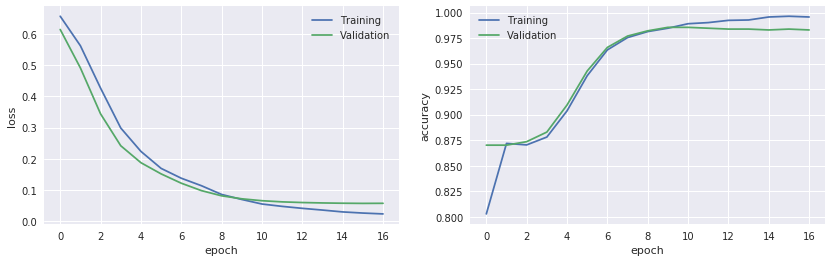


Training loss:  	0.0232
Validation loss: 	0.0572

Training accuracy: 	0.996
Validation accuracy:	0.983


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding

model = Sequential()
model.add(Embedding(max_words, 10, input_length=max_length))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Training ....')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=1)]
%time history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=0, \
                          validation_split = 0.3, callbacks=callbacks)

helper.show_training(history)

#### Evaluate Model

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest Accuracy: {:.3f}\n".format(score[1]))

y_pred = model.predict(x_test)

from sklearn.metrics import roc_auc_score

print('Neural Network ROC AUC: {:.3f} \n'.format(
    roc_auc_score(y_test, y_pred)))


Test Accuracy: 0.978

Neural Network ROC AUC: 0.990 



## 3. Compare with classical vectorizer + Multinomial Naive Bayes

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

x_train, y_train = df_train['text'], df_train['target']
x_test, y_test = df_test['text'], df_test['target']

vect = CountVectorizer().fit(x_train)

x_train_vectorized = vect.transform(x_train)

model = MultinomialNB(alpha=0.2).fit(x_train_vectorized, y_train)

predictions = model.predict(vect.transform(x_test))

print('\nMultinomialNB ROC_AUC: {:.3f}'.format(roc_auc_score(y_test, predictions)))


MultinomialNB ROC_AUC: 0.958
